# Variational Weight Uncertainty

In this exercise we'll implement Bayes by Backprop.

As background reading it is recommended that you read through the article "Practical Variational Inference for Neural Networks", Graves, NIPS 2011:
http://papers.nips.cc/paper/4329-practical-variational-inference-for-neural-networks.pdf

For the implementation of the model you must read the article "Weight Uncertainty in Neural networks", Blundell et al, ICML 2015:
http://jmlr.org/proceedings/papers/v37/blundell15.pdf

First we are running through some math to understand the variational inference for neural networks.

## Exercise 1
Use Jensen's inequality to show that, if $q(\theta)\ne 0$,

$\log p(y|x) \geq E_{q(\theta)}\left[ \log p(y|x,\theta)p(\theta) - \log q(\theta) \right]$

###Solution
The derivation looks as follows:

$\log p(y|x) =  \log \int_{\theta} p(\theta, y|x)d\theta$
			    
$=  \log \int_{\theta} p(y|x,\theta)p(\theta)d\theta$
				
$=  \log \int_{\theta} p(y|x,\theta) p(\theta)\frac{q(\theta)}{q(\theta)}d\theta$
             
$=  $ TODO: Continue... Think about expectations.

Now we use Jensen's inequality $f(E[X]) \geq E[f(X)]$ when f is concave ($\log(x)$ is concave since the second derivative is strictly negative), to push the log into the expectations.

$\log p(y|x) =  $ TODO: Finish the proof.

## Exercise 2
Now show that if $q(\theta)\ne 0,$

where $\mu$ is the mean vector and $D$ is a diagonal covariance matrix, then

$E_{q(\theta)}\left[ \log p(y|x,\theta)p(\theta) - \log q(\theta) \right] = E_{\mathcal{N}(\epsilon|0,I)}\left[ \log p(y|x,\theta)p(\theta) - \log q(\theta) \right]$



###Solution
To solve this problem you need to apply the reparameterization trick introduced in: http://arxiv.org/abs/1312.6114 and http://jmlr.org/proceedings/papers/v37/blundell15.pdf. 

The basic idea is to change the expectation from being over $q(\theta)$ to be over $p(\epsilon) \sim \mathcal{N}(0,I)$. We assume that the following is true:
$\theta = t(\theta,\epsilon)$.

Where $t(\theta,\epsilon)$ is a deterministic function and $\epsilon$ is distributed according to some distribution fulfilling: $p(\epsilon) d \epsilon = q(\theta)d\theta$.

From defining $q(\theta)=t(\theta,\epsilon)=\mathcal{N}(\mu,\sigma)$ it follows that,

$\theta \sim q(\theta) = t(\theta,\epsilon) = \mu + \sigma \epsilon$

$\epsilon \sim \mathcal{N}(0,I)$

Armed with these facts we perform the calculations:

TODO: Perform the calculations.

## Exercise 3
Show that if

$p(\theta) = \mathcal{N}(\theta|0,\sigma^2I)$

$q(\theta) = \mathcal{N}(\theta|\mu,D)$

$D = diag(\left[e^{2d_1},e^{2d_2},...,e^{2d_p}\right])$

$\mathcal{F}(\mu,D)=\mathbb{E}_{q(\theta)} \left[  \log p(x|\theta) p(\theta) - \log q(\theta) \right]$

Then if $\theta = \mu + D^{\frac{1}{2}}\epsilon$

$\frac{\partial \mathcal{F}(\mu,D)}{\partial \mu_i} = E_{\mathcal{N}(\epsilon|0,I)}\left[ \frac{\partial logp(y|x,\theta)}{\partial \theta} + \frac{\partial logp(\theta)}{\partial \theta} - \frac{\partial logq(\theta)}{\partial \theta} \right]$

$\frac{\partial \mathcal{F}(\mu,D)}{\partial d_i} = E_{\mathcal{N}(\epsilon|0,I)}\left[ (\frac{\partial logp(y|x,\theta)}{\partial \theta} + \frac{\partial logp(\theta)}{\partial \theta} - \frac{\partial logq(\theta)}{\partial \theta})e^{d_i} \epsilon_i \right]$

###Solution
In exercise 2 we showed that we could change from expectations over $q(\theta)$ to $p(\theta)$:

$\frac{\partial}{\partial\theta}\mathbb{E}_{q(\theta)} \left[  \log p(y|x,\theta) p(\theta) - \log q(\theta) \right]$

$= \frac{\partial}{\partial\theta}\mathbb{E}_{p(\epsilon)} \left[ \log p(y|x,\theta) p(\theta) - \log q(\theta)\right]$ 

$= \mathbb{E}_{p(\epsilon)} \left[ \frac{\partial}{\partial\theta}\log p(y|x,\theta)+ \frac{\partial}{\partial\theta}p(\theta) - \frac{\partial}{\partial\theta}\log q(\theta)  \right]$

Now we use the chain rule of derivatives, $\frac{\partial\theta}{\partial\mu_i} = 1$ and $\frac{\partial\theta}{\partial d_i} = e^{d_i}\epsilon_i$ to show that:

$\theta = \mu + D^{1/2} \epsilon = diag([e^{2d_1},e^{2d_2}\dots,^{2d_p}])$

$\frac{\partial \mathcal{F}}{\partial\mu_i} = $ TODO: Apply the chain rule.

$\frac{\partial \mathcal{F}}{\partial d_i} = $ TODO: Apply the chain rule.

## Exercise 4
What is the fewest number of times backpropagation be run to compute unbiased estimates both $\frac{\partial \mathcal{F}(\mu,D)}{\partial \mu_i}$ and $\frac{\partial \mathcal{F}(\mu,D)}{\partial d_i}$?

###Solution
How many samples do you need to make a monte carlo integral?

In [10]:
import numpy as np
import theano
theano.config.floatX = 'float32'
import theano.tensor as T
from lasagne.layers.base import Layer
from theano.tensor.shared_randomstreams import RandomStreams
from lasagne.nonlinearities import rectify, identity, linear
from lasagne.updates import adam, sgd
from lasagne.layers import get_all_layers, get_output, get_all_params, InputLayer
from lasagne import init
import math

##Exercise 5
Generate a simple regression data set by sampling points from the curve:

$y= x+0.3sin(2\pi(x+v))+0.3sin(4\pi(x+v))+v$

$v\sim\mathcal{N}(0,0.02)$

In [11]:
def _shared_dataset(data_xy, borrow=True):
    """
    Share the dataset for use on the GPU.
    :param data_xy: The data set containing a matrix x and y in a tuple.
    :param borrow: Refer to the theano docs.
    :return: The shared data set.
    """
    data_x, data_y = data_xy
    shared_x = theano.shared(np.asarray(data_x, dtype=theano.config.floatX), borrow=borrow)
    shared_y = theano.shared(np.asarray(data_y, dtype=theano.config.floatX), borrow=borrow)
    return shared_x, shared_y

def generate_synthetic_data(dat_size=1.e4):
    rng = np.random.RandomState(1234)
    x = rng.uniform(0., 1., dat_size).reshape((dat_size, 1))
    v = rng.normal(0, 0.02, size=x.shape)
    y = # TODO: Write y.
    # 90% for training, 10% testing
    train_x = x[:len(x)*0.9]
    train_y = y[:len(y)*0.9]
    test_x = x[len(x)*0.9:]
    test_y = y[len(y)*0.9:]
    return _shared_dataset((train_x, train_y)), _shared_dataset((test_x, test_y))

(train_x, train_t), (test_x, test_t) = generate_synthetic_data(1e4)
test_x_unshared = test_x.eval()
test_t_unshared = test_t.eval()

##Exercise 6
Construct a feed forward neural network that represents $p(y|x,\theta)$ with architecture 1-50-50-1. Run it on the generated data and evaluate the performance.

##Exercise 7
Implement a network for Bayes by Backdrop $p(\theta)$ and $q(\theta)$.

During training, estimate the loss function $\mathcal{F}(\mu,D)$ and likelihood $logp(y|x,\theta)$.

Following we'll write the functions for distribution density estimations.

In [12]:
c = - 0.5 * math.log(2*math.pi)
def normal(x, mean, sd):
    return c - T.log(T.abs_(sd)) - (x - mean)**2 / (2 * sd**2)

def normal2(x, mean, logvar):
    return c - logvar/2 - (x - mean)**2 / (2 * T.exp(logvar))

Construct the lasagne layer.

In [13]:
class BayesBackpropLayer(Layer):

    def __init__(self, incoming, num_units, W=init.Normal(0.05), b=init.Normal(0.05), nonlinearity=rectify,
                 prior_sd=T.exp(-3), **kwargs):
        super(BayesBackpropLayer, self).__init__(incoming, **kwargs)
        self._srng = RandomStreams()

        self.num_units = num_units
        self.num_inputs = int(np.prod(self.input_shape[1:]))
        self.nonlinearity = (identity if nonlinearity is None else nonlinearity)
        self.prior_sd = prior_sd

        self.W = T.zeros((self.num_inputs, num_units))
        self.W_mu = self.add_param(W, (self.num_inputs, num_units), name="W_mu")
        self.W_logsigma = self.add_param(W, (self.num_inputs, num_units), name="W_sigma")
        self.W_params = [self.W, self.W_mu, self.W_logsigma]
        self.b = T.zeros((num_units,))
        self.b_mu = self.add_param(b, (num_units,))
        self.b_logsigma = self.add_param(b, (num_units,))
        self.params = [self.W_mu, self.W_logsigma, self.b_mu, self.b_logsigma]

    def get_output_shape_for(self, input_shape):
        return (input_shape[0], self.num_units)

    def get_output_for(self, input, deterministic=False, **kwargs):
        if input.ndim > 2:
            # if the input has more than two dimensions, flatten it into a
            # batch of feature vectors.
            input = input.flatten(2)

        if deterministic:
            activation = T.dot(input, self.W_mu) + self.b_mu.dimshuffle('x', 0)
        else:
            W = self.get_W()
            b = self.get_b()
            activation = T.dot(input, W) + b.dimshuffle('x', 0)
        return self.nonlinearity(activation)

    def get_y_mu_sigma(self, x):
        layers = get_all_layers(self)
        # output from sampled weights of all layers-1.
        z = get_output(layers[-2], x, deterministic=False)
        # sampled output of the final layer.
        y = self.nonlinearity(T.dot(z, self.get_W()) + self.get_b().dimshuffle('x', 0))
        # mean output of the final layer.
        y_mu = self.nonlinearity(T.dot(z, self.W_mu) + self.b_mu.dimshuffle('x', 0))
        # logsigma output of the final layer.
        y_logsigma = self.nonlinearity(T.dot(z, self.W_logsigma) + self.b_logsigma.dimshuffle('x', 0))
        return y, y_mu, y_logsigma

    def get_log_distributions(self, x, t, n_samples=1):
        #TODO: calculate the log distributions.
        def one_sample(_x, _t):
            y, y_mu, y_logsigma = self.get_y_mu_sigma(_x)
            # logP(D|w)
            _log_pd_given_w = normal2(_t, y, T.log(self.prior_sd ** 2)).sum()
            # logq(w) logp(w)
            _log_qw, _log_pw = 0., 0.
            layers = get_all_layers(self)[1:]
            for layer in layers:
                W = layer.W
                b = layer.b
                _log_qw += normal2(W, layer.W_mu, layer.W_logsigma * 2).sum()
                _log_qw += normal2(b, layer.b_mu, layer.b_logsigma * 2).sum()
                _log_pw += normal(W, 0., self.prior_sd).sum()
                _log_pw += normal(b, 0., self.prior_sd).sum()
            return _log_qw, _log_pw, _log_pd_given_w

        log_qw, log_pw, log_pd_given_w = 0., 0., 0.
        for i in range(n_samples):
            log_qw_temp, log_pw_tmp, log_pd_given_w_tmp = one_sample(x, t)
            log_qw += log_qw_temp
            log_pw += log_pw_tmp
            log_pd_given_w += log_pd_given_w_tmp

        log_qw /= n_samples
        log_pw /= n_samples
        log_pd_given_w /= n_samples
        return log_qw, log_pw, log_pd_given_w

    def get_params(self):
        return self.params

    def get_W(self):
        # TODO: Sample the weights and return.
        W = T.zeros(self.W_mu.shape)
        eps = # Sample the epsilon.
        W += # Recall the reparameterization trick.
        self.W = W
        return W

    def get_b(self):
        # TODO: Sample the bias and return.
        b = T.zeros(self.b_mu.shape)
        eps = # Sample the epsilon.
        b += # Recall the reparameterization trick.
        self.b = b
        return b

Define the model class.

In [14]:
class VNN:
    def __init__(self, n_in, n_hidden, n_out, trans_func=rectify, out_func=linear, W=init.Normal(0.05),
                 b=init.Normal(0.05), batch_size=100, n_samples=10, prior_sd=T.exp(-3)):
        self.n_in = n_in
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.batch_size = batch_size
        self.transf = trans_func
        self.outf = out_func
        self.n_samples = n_samples
        self.l_in = InputLayer(shape=(batch_size,n_in))

        # Define the model
        l_prev = self.l_in
        for n_hid in n_hidden:
            l_tmp = BayesBackpropLayer(l_prev, num_units=n_hid, W=W, b=b, nonlinearity=self.transf, prior_sd=prior_sd)
            l_prev = l_tmp
        self.model = BayesBackpropLayer(l_prev, num_units=n_out, nonlinearity=self.outf)
        self.x = T.matrix('x')
        self.t = T.matrix('t')

    def build_model(self, train_x, train_t, test_x, test_t, update, update_args):
        self.train_x = train_x
        self.train_t = train_t
        self.test_x = test_x
        self.test_t = test_t
        self.update = update
        self.update_args = update_args
        self.index = T.iscalar('index')
        self.batch_slice = slice(self.index * self.batch_size, (self.index + 1) * self.batch_size)

        log_qw, log_pw, log_pd_given_w = self.model.get_log_distributions(self.x, self.t, self.n_samples)

        n_tot = self.train_x.shape[0].astype(theano.config.floatX)
        n_batches = n_tot / self.batch_size
        
        # TODO: Calculate the loss function. Remember to scale the weight difference by the batchsize.
        loss = ???

        all_params = get_all_params(self.model)
        updates = self.update(loss, all_params, *self.update_args)

        train_model = theano.function(
            [self.index], loss,
            updates=updates,
            givens={
                self.x: self.train_x[self.batch_slice],
                self.t: self.train_t[self.batch_slice],
            },
        )

        test_model = theano.function(
            [self.index], loss,
            givens={
                self.x: self.test_x[self.batch_slice],
                self.t: self.test_t[self.batch_slice],
            },
        )

        return train_model, test_model

    def get_output(self, dat, deterministic=False):
        return get_output(self.model, dat, deterministic=deterministic)

Run the network. Try to sample the weights multiple times and evaluate the difference.

In [ ]:
import time
batch_size = 100
n_epochs = 100
eval_train = {}
eval_test = {}

model = VNN(1, [50, 50], 1, trans_func=rectify, out_func=linear, batch_size=batch_size, n_samples=5)
train_model, test_model = model.build_model(train_x, train_t, test_x, test_t, adam, update_args=(0.001,))
n_train_batches = train_x.get_value(borrow=True).shape[0] / batch_size
n_test_batches = test_x.get_value(borrow=True).shape[0] / batch_size


done_looping = False
epoch = 0
for epoch in range(n_epochs):
    start_time = time.time()
    epoch += 1
    avg_costs = []
    for minibatch_index in xrange(n_train_batches):
        minibatch_avg_cost = train_model(minibatch_index)
        avg_costs.append(minibatch_avg_cost)
    eval_train[epoch] = np.mean(avg_costs)
    test_losses = [test_model(i) for i in xrange(n_test_batches)]

    eval_test[epoch] = np.mean(test_losses)

    end_time = time.time() - start_time
    print "[epoch,time,train,test];%i;%.2f;%.10f;%.10f" % (epoch, end_time, eval_train[epoch], eval_test[epoch])

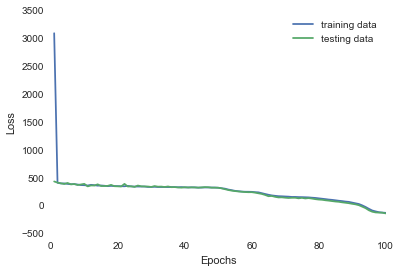

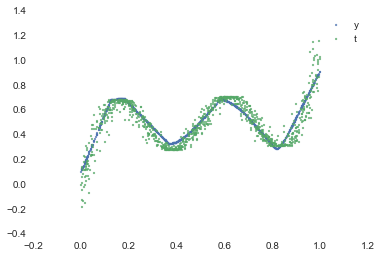

In [41]:
import math
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import time

fig = plt.figure()
plt.plot(eval_train.keys(), eval_train.values(), label='training data')
plt.plot(eval_test.keys(), eval_test.values(), label='testing data')
plt.legend()
plt.ylabel("Loss")
plt.xlabel('Epochs')
plt.show()

y = model.get_output(test_x, deterministic=False).eval()
fig = plt.figure()
plt.scatter(np.array(test_x_unshared), np.array(test_t_unshared), label="t", color=(1.0,0,0,0.2))
plt.scatter(np.array(test_x_unshared), np.array(y), label="y", color=(0,0.7,0,0.1))
plt.legend()
plt.show()